# Projekt prognoza pogody

## Pytania, pomysły, notatki

Potencjalne problemy:
- Normalnie pogodę prognozuje się [inaczej](https://en.wikipedia.org/wiki/Numerical_weather_prediction), bo pogoda zależy od innych czynników niż tylko przeszłe stany
- Modele lubią zauważać że pogoda zmienia się raczej wolno i przewidywać "jutro będzie tak jak dzisiaj"

Baseline:
- dzisiaj jest tak jak wczoraj
- zawsze średnia
- regresja liniowa
- regresja wielomianowa? (może być już fajna i przydatna do właściwych predykcji)

Lepsze pomysły:
- Metody uczenia zespołowego: Random Forest, AdaBoost, GradientBoost, XGBoost
  - "Małe" modele trenowane na podzbiorach danych z różnych okresów
  - jenen mały model przewiduje temperaturę za godzinę, drugi za dwie, itd, i potem z tego predykcja średniej temperatury danego dnia
  - do tego trzeba zrobić feature engineering: każda krotka dostaje dane o tym co się działo przez ostatni jakiś okres czasu (np temperatura wczoraj, średnia temperatura w tym tygodniu, miesiąc, pora roku) - chcemu obserwować sezonowość + lokalny trend
- Inne metody do operowania na szeregach czasowych (ich nie było na wykładzie)
  - Wygładzanie wykładnicze (Exponential Smoothing / Holt-Winters)
  - Statystyka: ARIMA / SARIMA
  - Modele addytywne: Facebook Prophet - jest dostępny za freeko, biblioteka `prophet`
- Dodać więcej stacji wokół punktu dla którego robimy predykcje. Wtedy można przewidywać na podstawie kierunku wiatru: jak wieje z północy do jutro będzie taka pogoda jak dzisiaj jest na północ od wrocławia.

---


## Dane

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
# from meteostat import Point, Daily
import meteostat as ms
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ustawienie ziarna losowości dla powtarzalności wyników
RANDOM_STATE = 42

Współrzędne geograficzne Wrocławia to:

* **Szerokość:** 51.1093° N
* **Długość:** 17.0386° E
* Wysokość n.p.m.: ~120

In [ ]:
# Specify location and time range
POINT = ms.Point(51.1093, 17.0386, 120)  # szerokość długość wysokość
START = date(2020, 1, 1) # TODO ustawić więcej, nie chciało mi się czekać aż się pobierze
END = date.today()

# Get nearby weather stations
stations = ms.stations.nearby(POINT, limit=4)
stations


,name,country,region,latitude,longitude,elevation,timezone,distance
id,,,,,,,,
12424,Wroclaw Copernicus Airport,PL,DO,51.1,16.8833,120,Europe/Warsaw,10892.1


In [ ]:
WROCLAW_STATION_ID=12424
df_daily = ms.daily(ms.Station(id=WROCLAW_STATION_ID), START, END).fetch()
df_hourly = ms.hourly(ms.Station(id=WROCLAW_STATION_ID), START, END).fetch()


Znaczenie kolumn w tabeli Meteostat "daily":

* **temp**: Średnia temperatura dobowa (°C)
* **tmin**: Minimalna temperatura (°C)
* **tmax**: Maksymalna temperatura (°C)
* **rhum**: Wilgotność względna (%)
* **prcp**: Dobowa suma opadów (mm)
* **wspd**: Średnia prędkość wiatru (km/h)
* **wpgt**: Najsilniejszy poryw wiatru (km/h)
* **pres**: Ciśnienie atmosferyczne na poziomie morza (hPa)
* **cldc**: Średnie zachmurzenie (%)

In [ ]:
df_daily.head()

,temp,tmin,tmax,rhum,prcp,snwd,wspd,wpgt,pres,tsun,cldc
time,,,,,,,,,,,
2020-01-01,1.9,-3.3,5.0,82,<NA>,<NA>,10.2,31.5,1033.1,<NA>,4
2020-01-02,-2.2,-7.5,6.2,81,0.0,<NA>,5.3,14.8,1028.9,<NA>,4
2020-01-03,1.1,-6.6,6.5,78,0.0,<NA>,13.9,31.5,1021.6,<NA>,4
2020-01-04,4.9,3.1,7.2,81,<NA>,<NA>,22.8,53.7,1018.5,<NA>,7
2020-01-05,1.0,-4.3,3.6,80,<NA>,<NA>,11.4,40.8,1031.3,<NA>,3


Znaczenie kolumn w danych godzinowych Meteostat:

| Kolumna | Znaczenie | Jednostka |
| --- | --- | --- |
| **temp** | Temperatura powietrza | °C |
| **rhum** | Wilgotność względna | % |
| **prcp** | Opady (godzinowa suma) | mm |
| **snwd** | Głębokość pokrywy śnieżnej | mm |
| **wdir** | Kierunek wiatru | stopnie (0-360°) |
| **wspd** | Średnia prędkość wiatru | km/h |
| **wpgt** | Szczytowy poryw wiatru | km/h |
| **pres** | Ciśnienie atmosferyczne (na poz. morza) | hPa |
| **tsun** | Czas nasłonecznienia w danej godzinie | minuty |
| **cldc** | Zachmurzenie ogólne | oktawy (0-8) lub % |
| **coco** | Kod warunków pogodowych (Condition Code) | (numeryczny) |

`coco`: To kody liczbowe (np. 1 = Clear, 3 = Cloudy, 14 = Thunderstorm).

In [ ]:
df_hourly.head()

,temp,rhum,prcp,snwd,wdir,wspd,wpgt,pres,tsun,cldc,coco
time,,,,,,,,,,,
2020-01-01 00:00:00,2.7,81,<NA>,<NA>,300,7.2,24.1,1032.5,<NA>,1,1
2020-01-01 01:00:00,3.9,80,<NA>,<NA>,300,10.8,24.1,1032.6,<NA>,6,3
2020-01-01 02:00:00,2.6,86,<NA>,<NA>,290,10.8,22.2,1032.8,<NA>,5,3
2020-01-01 03:00:00,3.4,78,<NA>,<NA>,300,10.8,22.2,1032.9,<NA>,3,3
2020-01-01 04:00:00,2.8,85,<NA>,<NA>,290,10.8,22.2,1033.4,<NA>,7,3


In [ ]:
print(df_hourly.isna().sum())
print(df_hourly.isna().mean() * 100)
print(df_daily.isna().sum())
print(df_daily.isna().mean() * 100)

temp        0
rhum        1
prcp    21529
snwd    52762
wdir        0
wspd        0
wpgt      263
pres        0
tsun    52920
cldc     1974
coco      185
dtype: int64
temp      0.000000
rhum      0.001890
prcp     40.682162
snwd     99.701436
wdir      0.000000
wspd      0.000000
wpgt      0.496977
pres      0.000000
tsun    100.000000
cldc      3.730159
coco      0.349584
dtype: float64
temp       0
tmin       0
tmax       0
rhum       0
prcp     633
snwd    2158
wspd       0
wpgt      11
pres       0
tsun    2205
cldc     179
dtype: int64
temp      0.000000
tmin      0.000000
tmax      0.000000
rhum      0.000000
prcp     28.707483
snwd     97.868481
wspd      0.000000
wpgt      0.498866
pres      0.000000
tsun    100.000000
cldc      8.117914
dtype: float64


## Szybki teścik: regresja liniowa + random forest

**To jest na danych dziennych, ale pewnie docelowe chcemy używać tych godzinowych**

In [ ]:
df = df_daily

df['Target'] = df['temp'].shift(1)

# Cechy: Co wiedzieliśmy WCZORAJ i wcześniej?
df['T_dzisiaj'] = df['temp'].shift(-1)
df['T_wczoraj'] = df['temp'].shift(-2)
df['T_3dnitemu'] = df['temp'].shift(-3)
df['temp_change'] = df['temp'].diff()

# Średnia krocząca z 3 dni
df['Rolling_Mean_7'] = df['temp'].rolling(window=7).mean().shift(-7)

# Dodajemy informacje o sezonie
df['Month'] = df.index.month
df['DayOfYear'] = df.index.dayofyear

In [ ]:
# Usuwamy kolumny z brakami
df = df.drop(columns=['snwd', 'tsun'])
df = df.dropna()

In [ ]:
# Definiujemy cechy (X) i cel (y)
features = ['temp_change','T_wczoraj', 'T_dzisiaj', 'T_3dnitemu', 'Rolling_Mean_7', 'Month', 'prcp', 'wspd', 'pres', 'rhum']
target = 'Target'

X = df[features]
y = df[target]

# Podział chronologiczny (np. ostatni rok to test)
test_days = 365
X_train, X_test = X.iloc[:-test_days], X.iloc[-test_days:]
y_train, y_test = y.iloc[:-test_days], y.iloc[-test_days:]

print(f"Trening: {X_train.shape}, Test: {X_test.shape}")

Trening: (1123, 10), Test: (365, 10)


In [ ]:
# 1. Baseline: Regresja Liniowa
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# 2. Model Główny: Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=RANDOM_STATE)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

--- Regresja Liniowa ---
MAE (średni błąd bezwzględny): 1.64 °C
RMSE (błąd średniokwadratowy): 2.04 °C
--- Random Forest ---
MAE (średni błąd bezwzględny): 1.73 °C
RMSE (błąd średniokwadratowy): 2.17 °C


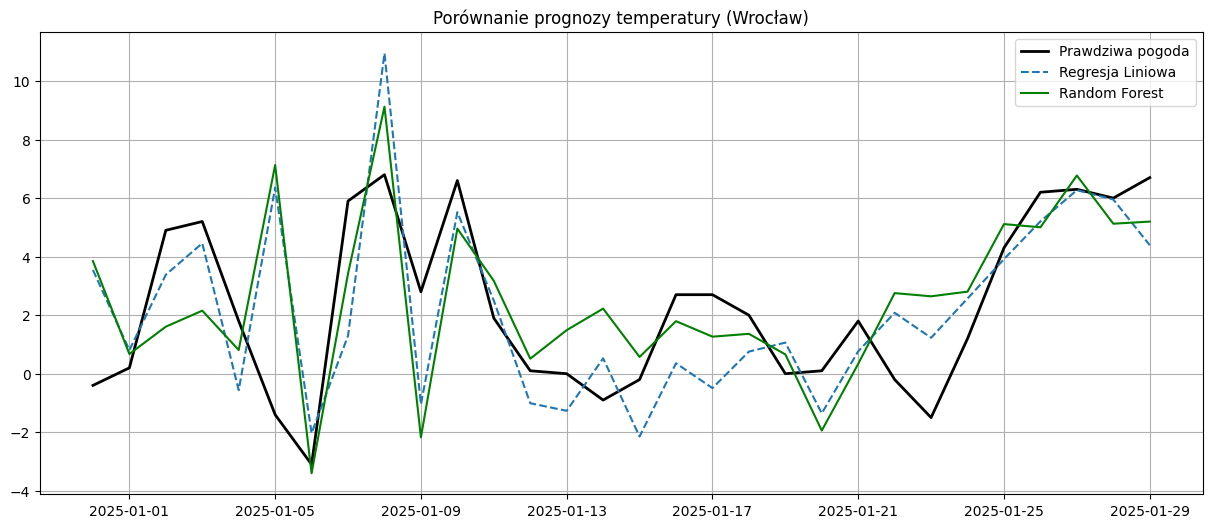

In [ ]:
# Funkcja do oceny
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"--- {model_name} ---")
    print(f"MAE (średni błąd bezwzględny): {mae:.2f} °C")
    print(f"RMSE (błąd średniokwadratowy): {rmse:.2f} °C")

evaluate(y_test, lr_preds, "Regresja Liniowa")
evaluate(y_test, rf_preds, "Random Forest")

# Wizualizacja (tylko pierwszy miesiąc testowy dla czytelności)
plt.figure(figsize=(15, 6))
plt.plot(y_test.index[:30], y_test.values[:30], label='Prawdziwa pogoda', color='black', linewidth=2)
plt.plot(y_test.index[:30], lr_preds[:30], label='Regresja Liniowa', linestyle='--')
plt.plot(y_test.index[:30], rf_preds[:30], label='Random Forest', color='green')
plt.title("Porównanie prognozy temperatury (Wrocław)")
plt.legend()
plt.grid(True)
plt.show()

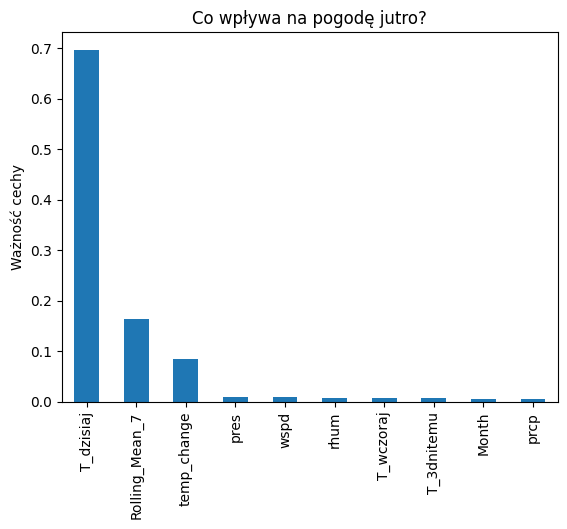

In [ ]:

importances = rf_model.feature_importances_
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

forest_importances.plot.bar()
plt.title("Co wpływa na pogodę jutro?")
plt.ylabel("Ważność cechy")
plt.show()

## Metody ensemble

### Implementacja + ewaluacja któregoś z pomysłów (TODO)

np to:

jenen mały model przewiduje temperaturę za godzinę, drugi za dwie, itd, i potem z tego predykcja średniej temperatury danego dnia


### Implementacja + ewaluacja innego pomysłu (TODO)